In [1]:
pip install torch matplotlib numpy pandas

In [2]:
pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 38.9 MB/s eta 0:00:00


In [3]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00


In [4]:
pip install pyngrok

# Setting up MLflow Tracking UI and ngrok Tunnel

In [5]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok

# Terminate open tunnels if they exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2qtNcpY0pfgni2yMzmQ6Xxk9nrD_4FFQ3Vb1sbfNqRb6czn7V"
ngrok.set_auth_token(NGROK_AUTH_TOKEN) # set authtoken

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr = "5000", proto = "http", bind_tls = True)

print("MLflow Tracking UI:", ngrok_tunnel.public_url) # Print the public URL

MLflow Tracking UI: https://7ae5-34-87-54-156.ngrok-free.app


## Importing Required Libraries and Mounting Google Drive

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Loading and Preparing EMNIST Dataset

In [8]:
emnist_train_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FullStackDeepLearning/final_code/datasets/emnist-letters-train.csv")

emnist_test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FullStackDeepLearning/final_code/datasets/emnist-letters-test.csv")

## Defining the EMNIST Dataset Class

In [9]:
class EMNISTDataset(Dataset): # inherit from torch.utils.data.Dataset
    def __init__(self, dataframe): # initialize the class

        self.images = torch.tensor(dataframe.iloc[:, 1:].values, dtype= torch.float32) # get all pixel values

        self.labels = torch.tensor(dataframe.iloc[:, 0].values, dtype = torch.float32) # get all labels
 
    def __len__(self): # return length of the dataset
        return len(self.images) # return the number of images

    def __getitem__(self, idx): # return data and labels for a given index
        images = self.images[idx] # get image at the specified index

        images = images / 255.0 # normalize the pixel values
        labels = self.labels[idx] # get label at the specified index

        return images, labels # return image and label

In [10]:
emnist_test_data = emnist_test_data.sample(frac = 1) # shuffle the test data

In [11]:
train_dataset = EMNISTDataset(emnist_train_data) # create train dataset

test_dataset = EMNISTDataset(emnist_test_data ) # create test dataset

In [12]:
from torch.utils.data import random_split  

val_percent = 0.1
val_len = int(val_percent * len(train_dataset)) # 10% of the training data

train_ds, val_ds = random_split(train_dataset, [len(train_dataset) - val_len, val_len]) # split the training data into train and validation

## Creating DataLoaders for Training, Validation, and Testing

In [13]:
batch_size = 64 # batch size

train_dataloader = DataLoader(train_ds, batch_size, shuffle = True, drop_last = True, num_workers=1) # create train dataloader

val_dataloader = DataLoader(val_ds, batch_size, num_workers=1) # create validation dataloader

test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1) # create test dataloader

len(train_dataloader), len(val_dataloader), len(test_dataloader) # check the length of the dataloaders

(1248, 139, 232)

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl

from torchmetrics.functional import accuracy

## Setting Up MLflow Experiment

In [15]:
import mlflow 

experiment_id = mlflow.create_experiment(name = "emnist_letters_prediction_using_cnn") # create an experiment

mlflow.set_experiment(experiment_name = "emnist_letters_prediction_using_cnn") # set the experiment

<Experiment: artifact_location='file:///content/mlruns/507501602153471105', creation_time=1735981732044, experiment_id='507501602153471105', last_update_time=1735981732044, lifecycle_stage='active', name='emnist_letters_prediction_using_cnn', tags={}>

## Defining and Training the EMNIST Model

In [16]:
class EmnistModel(pl.LightningModule): # inherit from pl.LightningModule
    def __init__(self): # initialize the class
        super().__init__() # initialize the parent class

        self.criterion = nn.CrossEntropyLoss() # define the loss function

        self.network = nn.Sequential( # define the network
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1), # 32 * 28 * 28
            nn.ReLU(), # activation function
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1), # 64 * 28 * 28
            nn.ReLU(), # activation function
            nn.MaxPool2d(2, 2), # 64 * 14 * 14 # activation

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1), # 128 * 14 * 14
            nn.ReLU(), # activation function 
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1), # 256 * 14 * 14
            nn.ReLU(), # activation function
            nn.MaxPool2d(2, 2), #256 * 7 * 7

            nn.Flatten(), # flatten the output
            nn.Linear(256*7*7, 32), # linear layer
            nn.ReLU(), # activation function

            nn.Linear(32, 64), # linear layer
            nn.ReLU(), # activation function

            nn.Linear(64, 26) # linear layer
        )

    def forward(self, xb): # forward pass
        return self.network(xb.reshape(-1, 1, 28, 28)) # reshape the input and pass it through the network

    def configure_optimizers(self): # configure the optimizer
        return optim.Adam(self.parameters(), lr = 0.0001) # return the optimizer

    def training_step(self, batch, batch_idx): # training step
        x, y = batch # get data and labels
        y -= 1 # subtract 1 from the labels

        y_hat = self(x) # get predictions
        loss = self.criterion(y_hat, y.long()) # calculate the loss
        pred = y_hat.argmax(dim = 1) # get the predictions

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26) # calculate the accuracy

        self.log("train_loss", loss, on_epoch = True, prog_bar = True) # log the training loss
        self.log("train_acc", acc, on_epoch = True, prog_bar = True) # log the training accuracy

        return loss # return the loss

    def validation_step(self, batch, batch_idx): # validation step
        x, y = batch # get data and labels
        y -= 1 # subtract 1 from the labels

        y_hat = self(x) # get predictions
        loss = self.criterion(y_hat, y.long()) # calculate the loss
        pred = y_hat.argmax(dim = 1) # get the predictions

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26) # calculate the accuracy

        self.log("valid_loss", loss, on_epoch = True, prog_bar = True) # log the validation loss
        self.log("valid_acc", acc, on_epoch = True, prog_bar = True) # log the validation accuracy
        return acc # return the accuracy

    def test_step(self, batch, batch_idx): # test step
        x, y = batch # get data and labels
        y -= 1 # subtract 1 from the labels

        y_hat = self(x) # get predictions
        loss = self.criterion(y_hat, y.long()) # calculate the loss
        pred = y_hat.argmax(dim = 1) # get the predictions

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26) # calculate the accuracy 

        self.log("test_loss", loss, logger = True) # log the test loss
        self.log("test_acc", acc, logger = True) # log the test accuracy

        return acc # return the accuracy


    def predict_step(self, batch, batch_idx, dataloader_idx = 0): # predict step

        return self(x) # return the predictions

## Training the Model with MLflow Logging

In [17]:
from mlflow.models.signature import ModelSignature 
from mlflow.types.schema import ColSpec, Schema, TensorSpec
from pytorch_lightning.loggers import CSVLogger

emnist_model = EmnistModel() # create an instance of the model

logger = CSVLogger("logs", name = "emnist_letters_classification") # create a logger

trainer = pl.Trainer(max_epochs = 10, logger = logger) # create a trainer

mlflow.pytorch.autolog(log_models = False) # enable autologging

with mlflow.start_run() as run: # start the mlflow run

    trainer.fit(emnist_model, train_dataloader, val_dataloader) # fit the model
    trainer.test(dataloaders = test_dataloader) # test the model

    input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1, 28, 28))]) # define the input schema
    output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))]) # define the output schema
    signature = ModelSignature(inputs = input_schema, outputs = output_schema) # define the signature

    mlflow.pytorch.log_model(emnist_model, "emnist-letters-classifier-cnn-model", signature = signature) # log the model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2025/01/04 09:08:52 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.5.1, but the installed version is 2.5.1+cu121. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.
2025/01/04 09:08:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/pytorch/_lightning_autolog.py:465: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.9.0 and 2.4.0 and may not succeed with packages outside this range."
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:09:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:09:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:09:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:10:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:10:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:11:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:11:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:11:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:12:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:12:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/emnist_letters_classification/version_0/checkpoints/epoch=9-step=12480.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.util

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9085748791694641     │
│         test_loss         │    0.2831708490848541     │
└───────────────────────────┴───────────────────────────┘

2025/01/04 09:12:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/04 09:12:39 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}


## Evaluating Model Performance

In [18]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv") # read the metrics file

metrics # evaluate the model

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,valid_acc,valid_loss
0,0,49,NaN,NaN,NaN,0.062500,NaN,3.162338,NaN,NaN
1,0,99,NaN,NaN,NaN,0.187500,NaN,2.599558,NaN,NaN
2,0,149,NaN,NaN,NaN,0.484375,NaN,1.951115,NaN,NaN
3,0,199,NaN,NaN,NaN,0.515625,NaN,1.633257,NaN,NaN
4,0,249,NaN,NaN,NaN,0.500000,NaN,1.514114,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
265,9,12399,NaN,NaN,NaN,0.890625,NaN,0.325036,NaN,NaN
266,9,12449,NaN,NaN,NaN,0.937500,NaN,0.133875,NaN,NaN
267,9,12479,NaN,NaN,NaN,NaN,NaN,NaN,0.922739,0.24568
268,9,12479,NaN,NaN,0.947478,NaN,0.152878,NaN,NaN,NaN


<Axes: xlabel='epoch'>

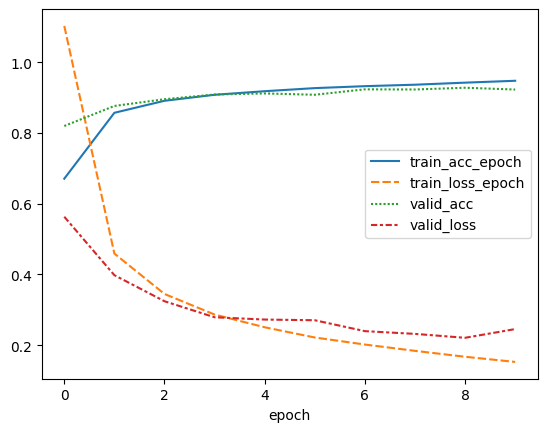

In [19]:
import seaborn as sns

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)
metrics.drop(columns = ['step', 'train_loss_step',
                        'train_acc_step', 'test_acc', 'test_loss'], inplace = True)

# Plot the training and validation loss and accuracy over epochs
sns.lineplot(data = metrics)

In [20]:
run_id = mlflow.last_active_run().info.run_id # get the run id

run_id # print the run id

'36d42a13364f43c3b1a006f2fa56e1d3'

### Fetching a Batch of Test Data

In [21]:
test_dataiter = iter(test_dataloader) # create an iterator for the test dataloader

test_imgs, test_labels = next(test_dataiter) # iterate over the test dataset

test_imgs.shape, test_labels.shape # check the shape of the test images and labels

(torch.Size([64, 784]), torch.Size([64]))

## Making Predictions with the Loaded Model

In [22]:
logged_model = f'runs:/{run_id}/emnist-letters-classifier-cnn-model' # get the path of the logged model

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model) # load the model

predictions = loaded_model.predict(test_imgs.numpy().reshape(-1, 1, 28, 28)) # get predictions

predictions[:5] # print the predictions

array([[  8.612576  ,   1.6144208 ,  -7.961303  ,  -8.670675  ,
         -3.7802913 ,   4.8998413 ,  10.312441  ,  -4.8671374 ,
         -4.0944524 ,  -0.62833893, -10.382958  ,  -7.516913  ,
         -9.091114  ,  -4.983686  ,  -8.443363  ,   4.14391   ,
         13.055735  ,   3.7398942 ,  -0.64457566,   3.8712187 ,
        -15.559979  , -16.32241   , -10.802368  ,   5.0374227 ,
          1.7804024 ,   7.0382504 ],
       [  2.2635248 ,  -8.395779  , -19.332848  ,   3.6943    ,
        -23.638988  , -15.637228  ,   0.30645227,   4.925696  ,
        -16.931091  , -10.868864  ,  -2.9705982 ,  -5.0645967 ,
         17.58423   ,  10.688254  ,  -7.5330014 ,  -2.9428415 ,
         -2.2277312 ,  -2.0552547 , -20.097895  , -11.591249  ,
          8.494412  ,  -1.2494175 ,   4.26194   ,  -6.4809365 ,
          7.7688155 , -15.975087  ],
       [ -0.10895085,  -4.874157  ,  -3.2489042 ,  -0.509805  ,
         -7.7714596 ,  -1.7418045 ,  -3.367111  ,   0.7413956 ,
          8.9553385 ,   3.9595

In [24]:
predictions.shape # check the shape of the predictions

(64, 26)

In [25]:
test_labels[2] # get the label of the third image

tensor(12.)

In [26]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [27]:
classes[int(test_labels[2].item())-1] # get the label of the third image as a string in the class

'l'

In [28]:
predictions[2] # get the label of the third image

array([-0.10895085, -4.874157  , -3.2489042 , -0.509805  , -7.7714596 ,
       -1.7418045 , -3.367111  ,  0.7413956 ,  8.9553385 ,  3.9595025 ,
       -4.5922723 ,  9.206609  , -5.949102  ,  0.5189272 , -7.4964514 ,
       -8.697129  , -2.7384877 , -1.4702839 , -4.2220516 ,  5.0594726 ,
       -2.586972  , -1.6038061 , -3.3573673 , -1.5613363 ,  1.8406286 ,
        0.15249363], dtype=float32)

In [29]:
classes[np.argmax(predictions[2])] # get the predicted label of the third image

'l'

We conclude from above that the predicted label and the actual label is true for both.

## Visualizing Model Predictions

In [30]:
def show(idx, title): # show the model

    plt.figure() # create a figure
    plt.imshow(test_imgs.squeeze()[idx].numpy().reshape( 28, 28), cmap = "gray") # plot the image

    plt.axis("off") # turn off the axis
    plt.title("\n\n{}".format(title), fontdict = {"size": 16}) # set the title

<ipython-input-30-14749e72c093>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


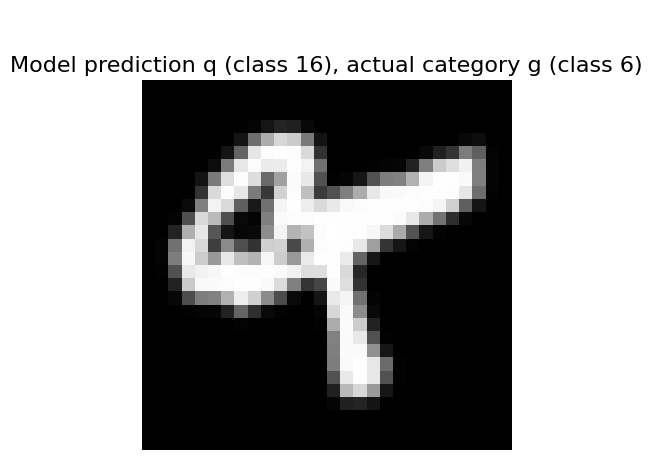

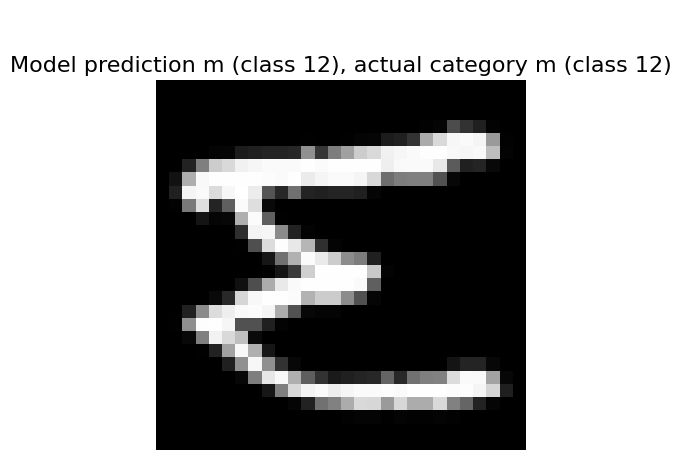

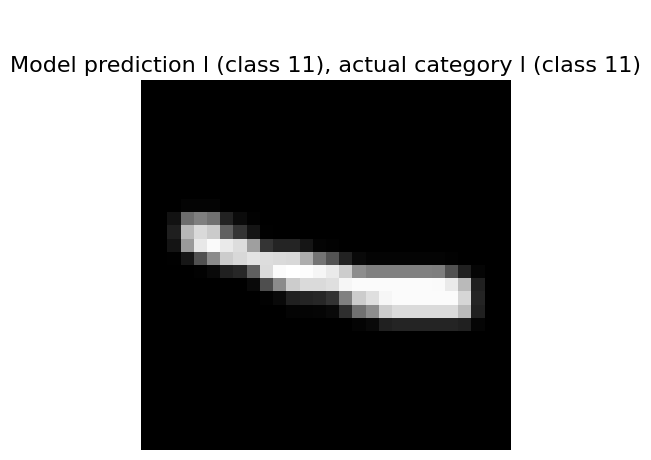

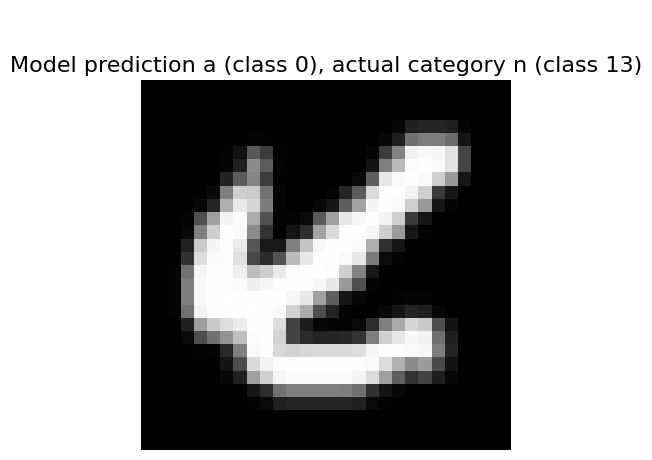

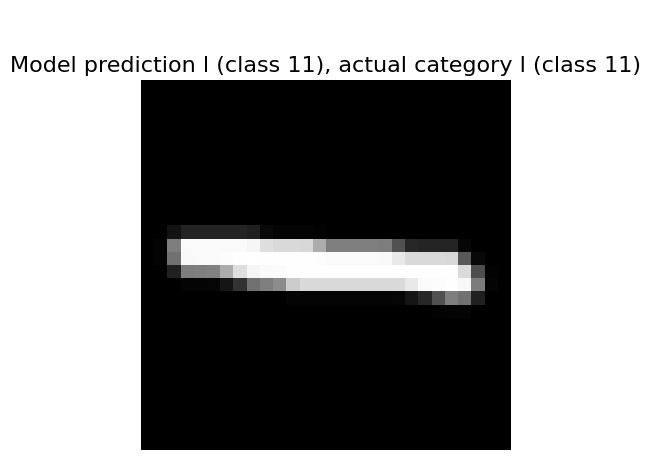

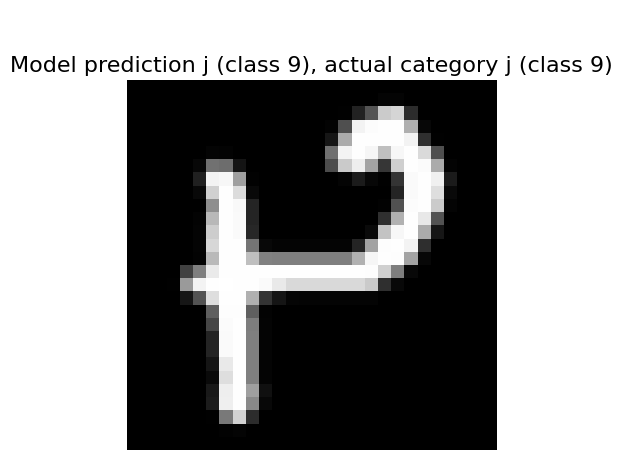

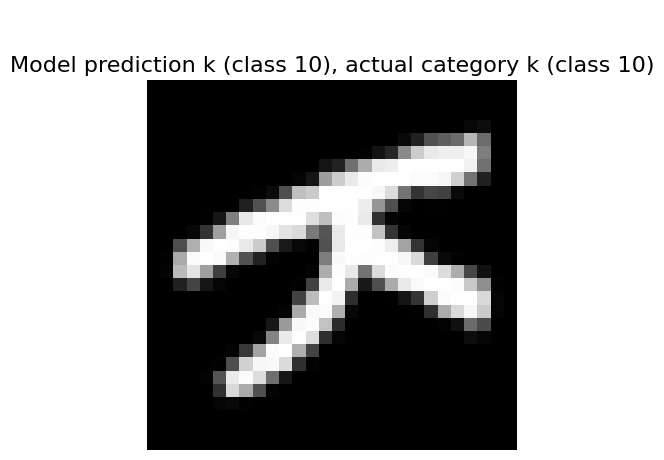

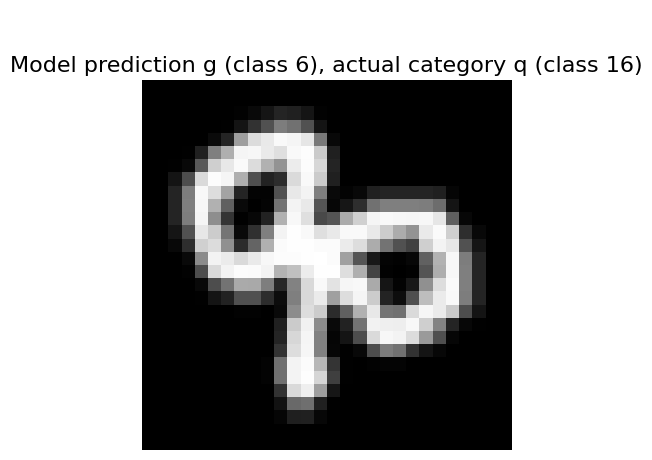

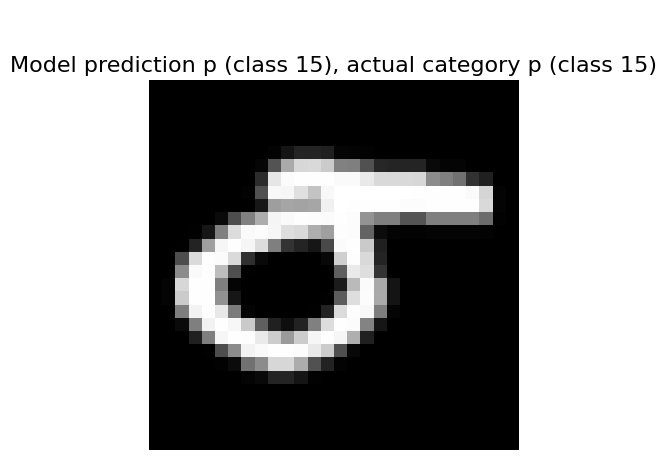

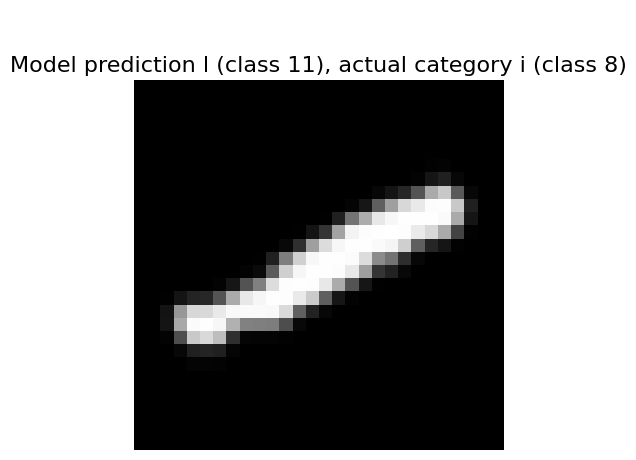

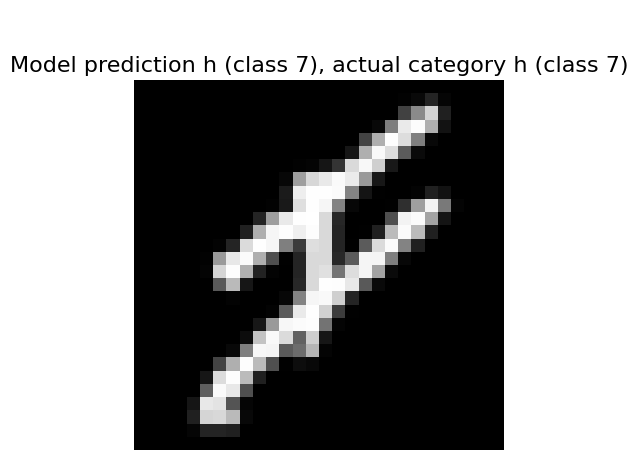

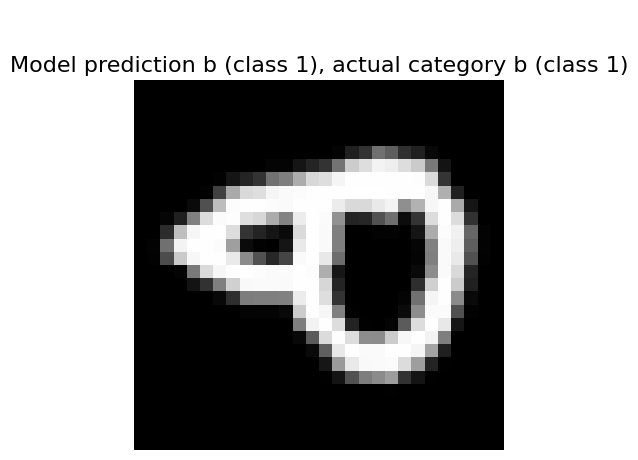

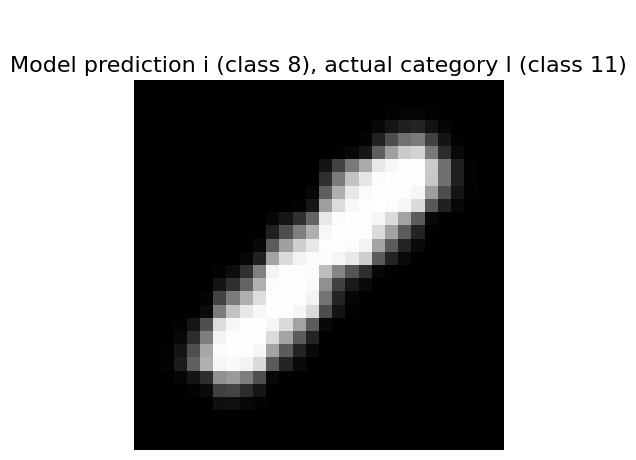

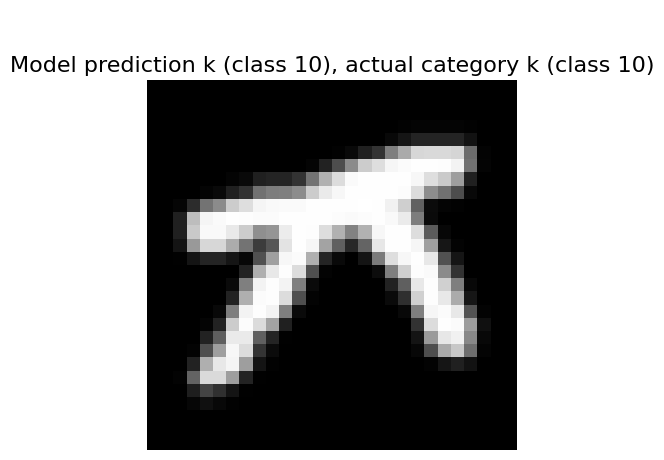

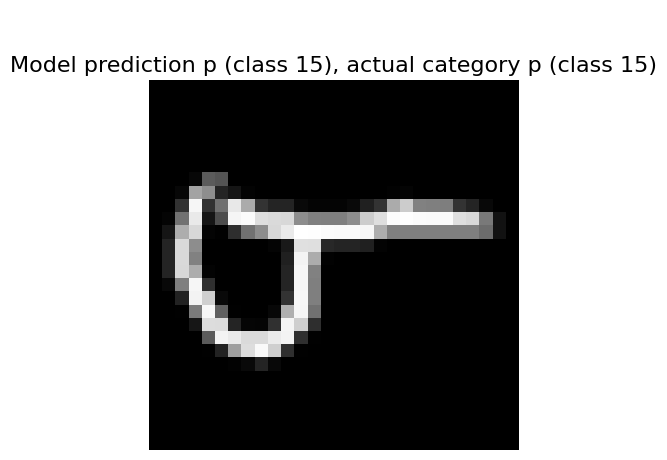

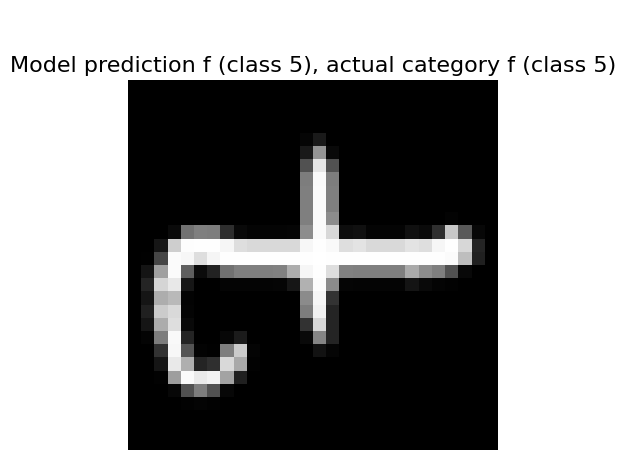

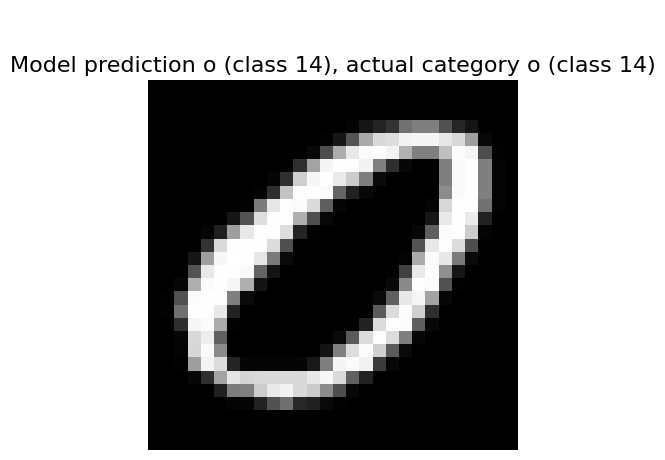

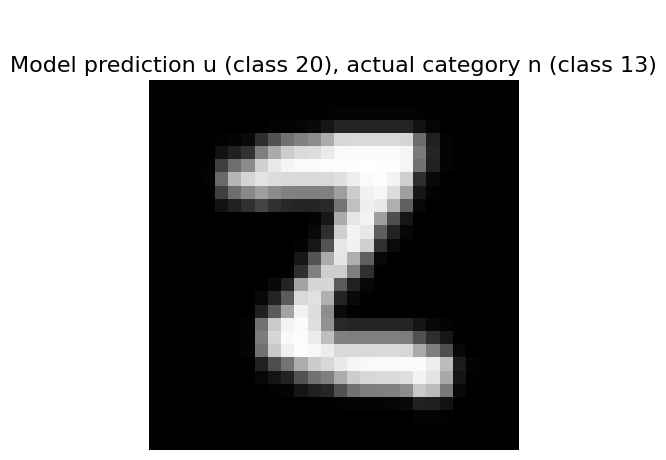

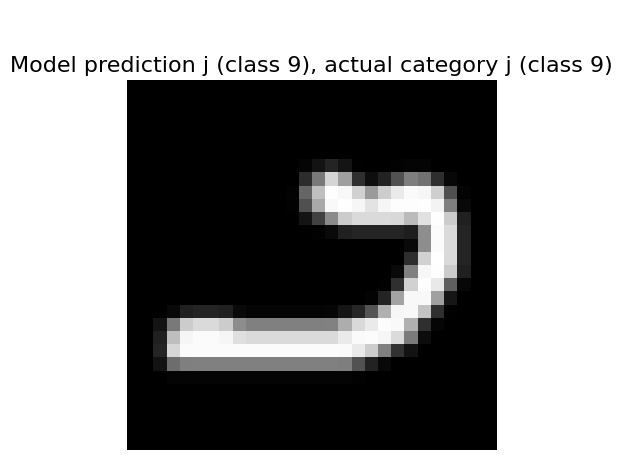

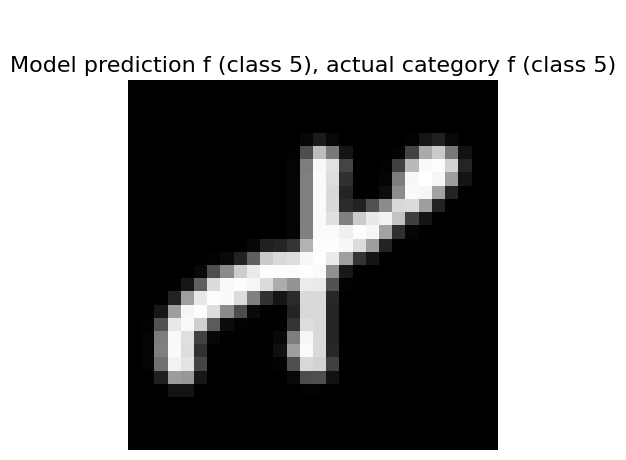

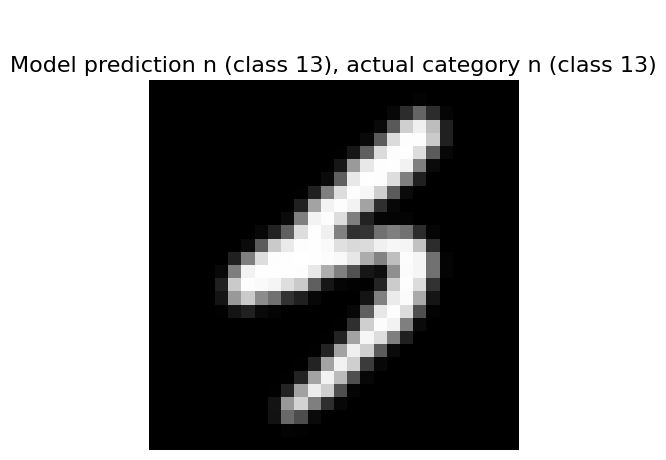

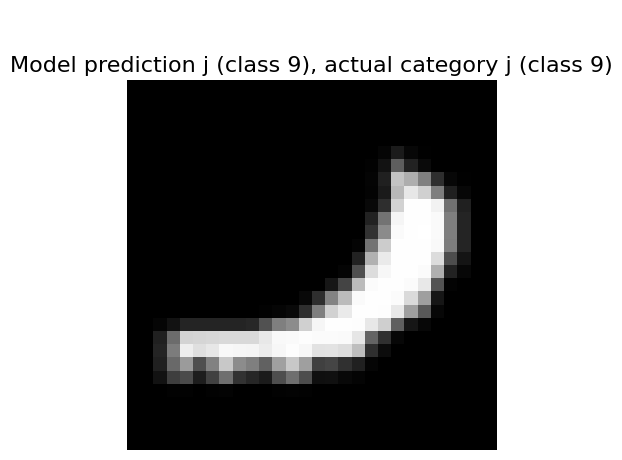

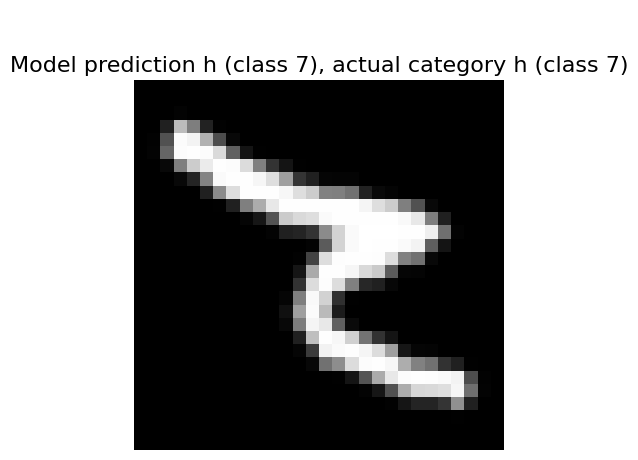

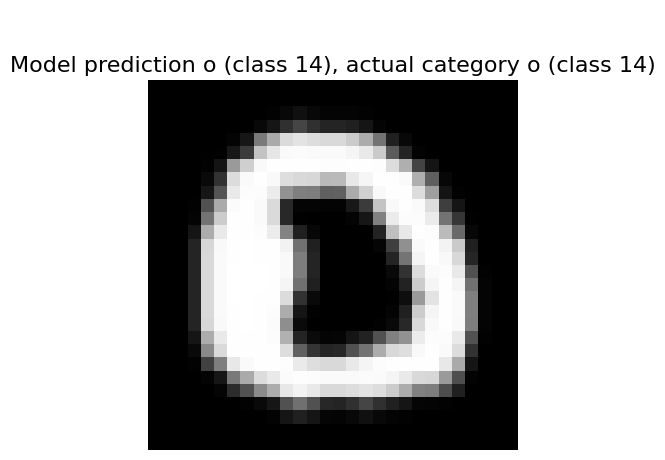

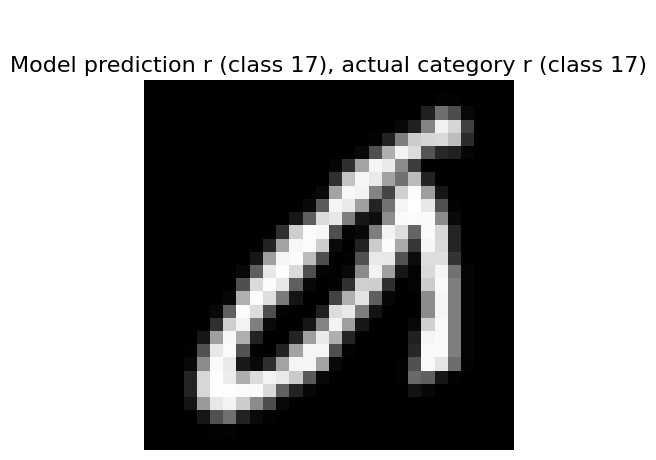

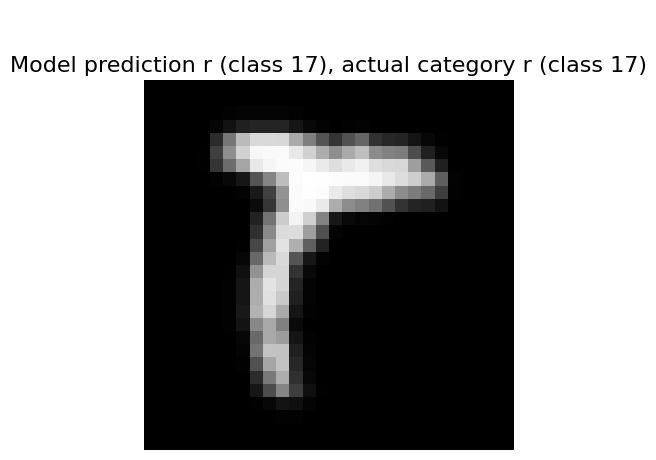

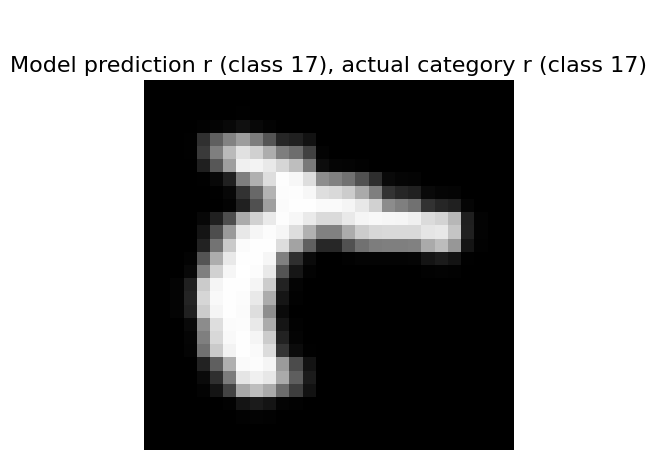

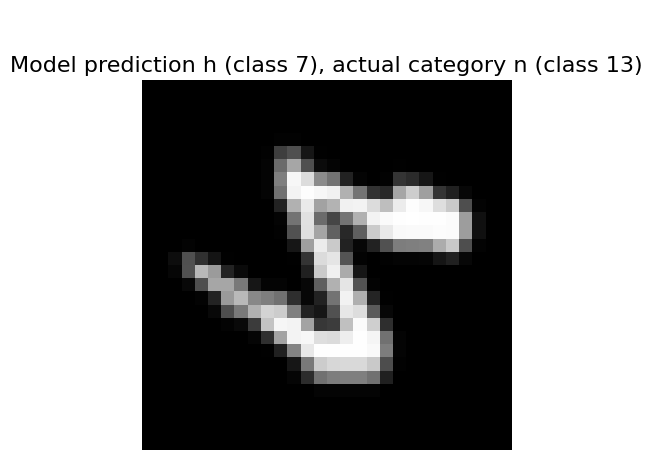

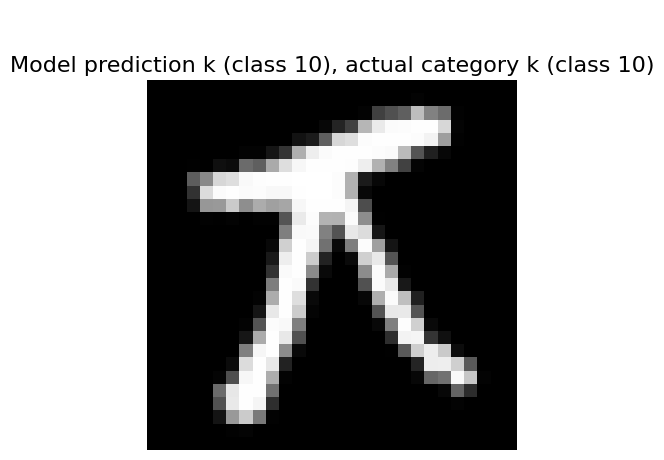

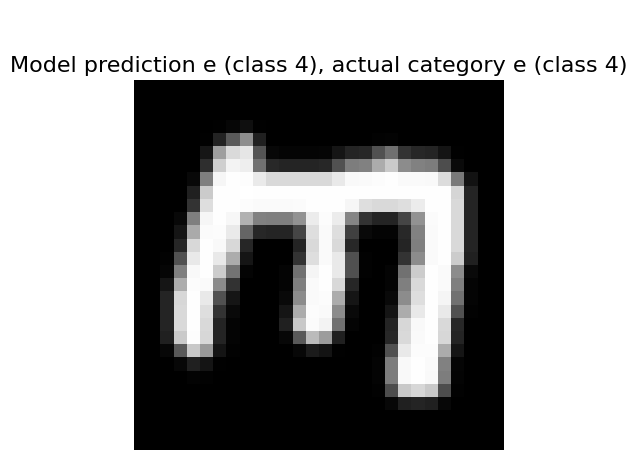

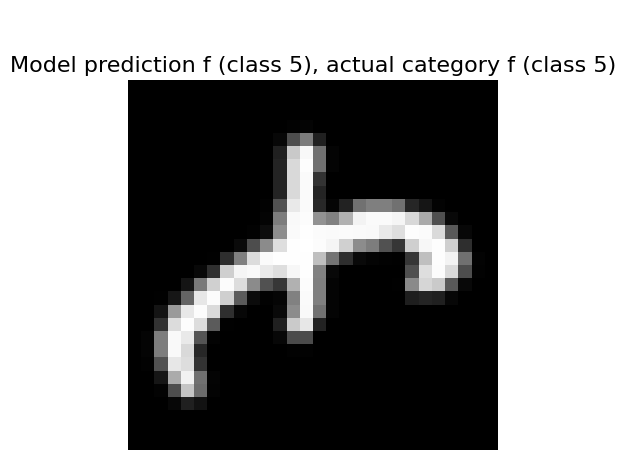

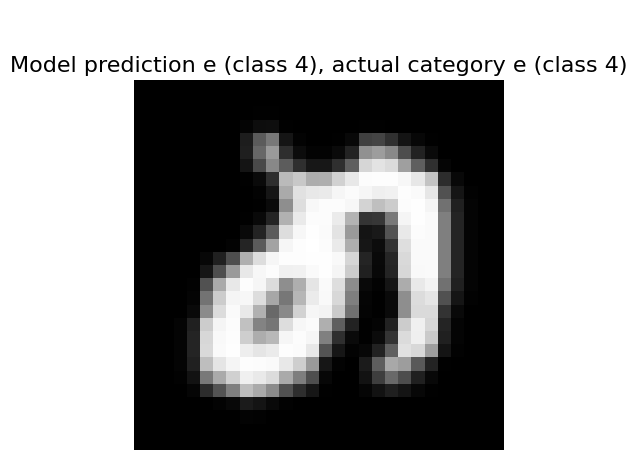

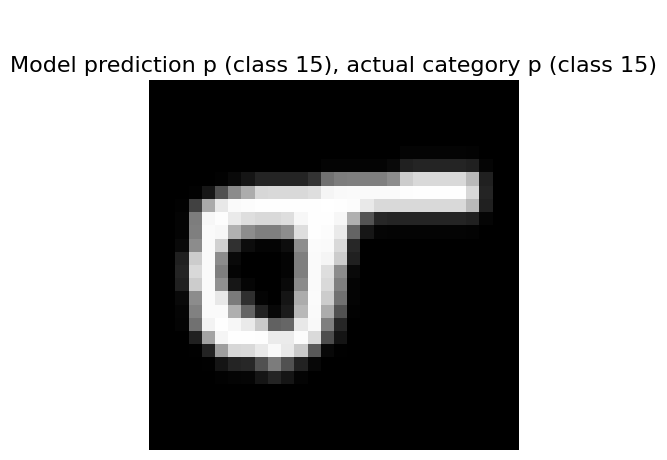

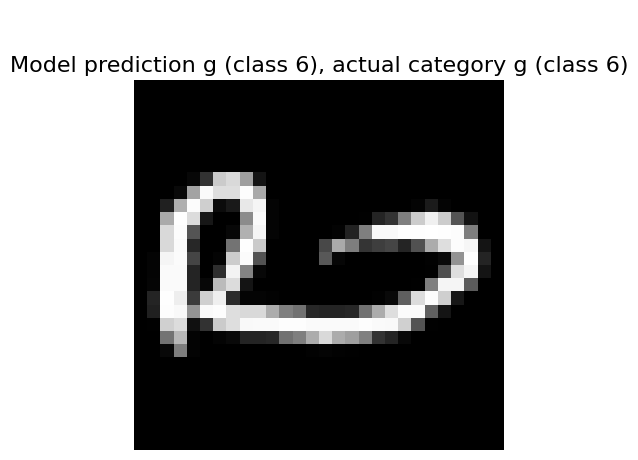

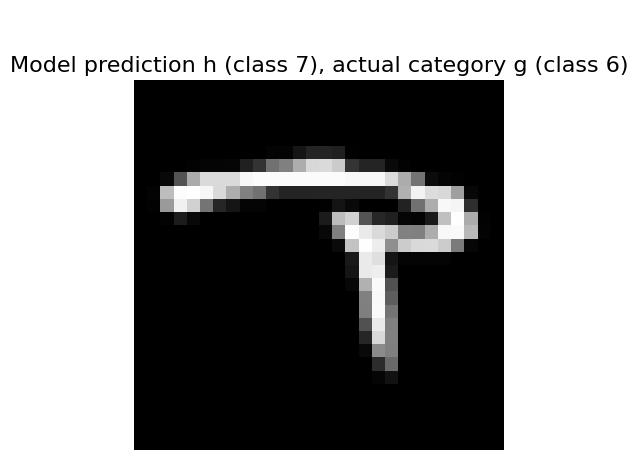

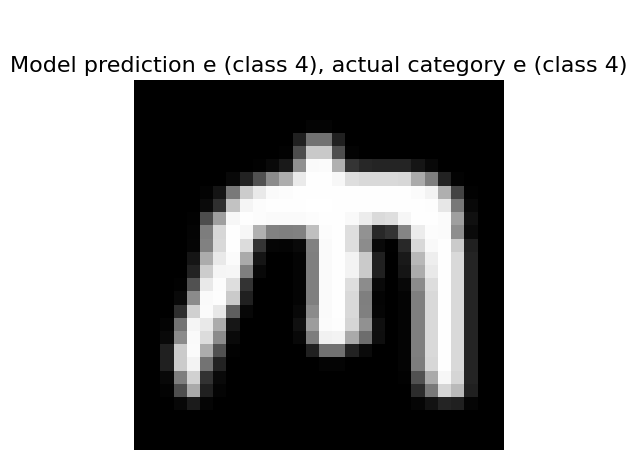

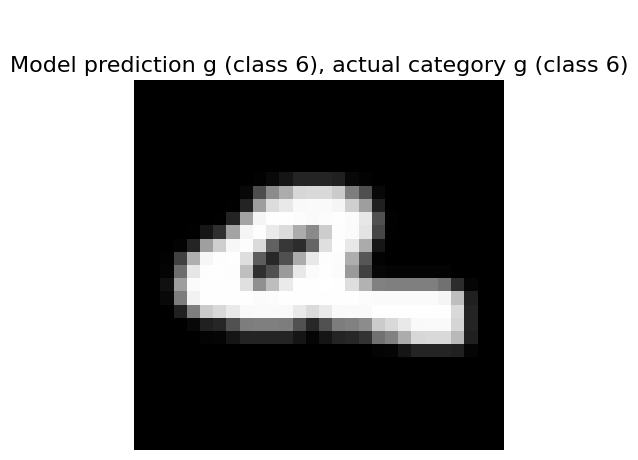

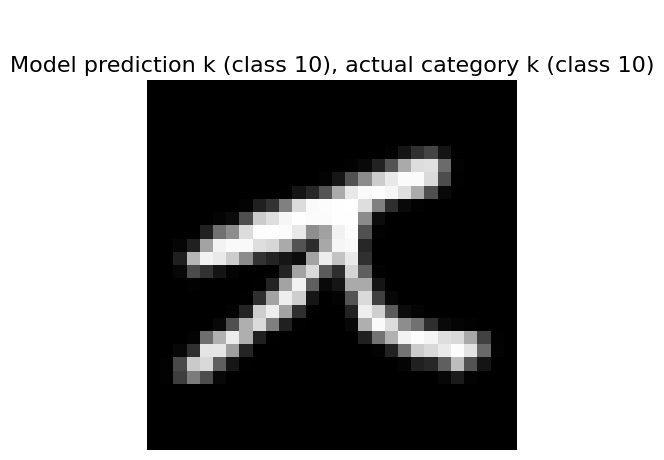

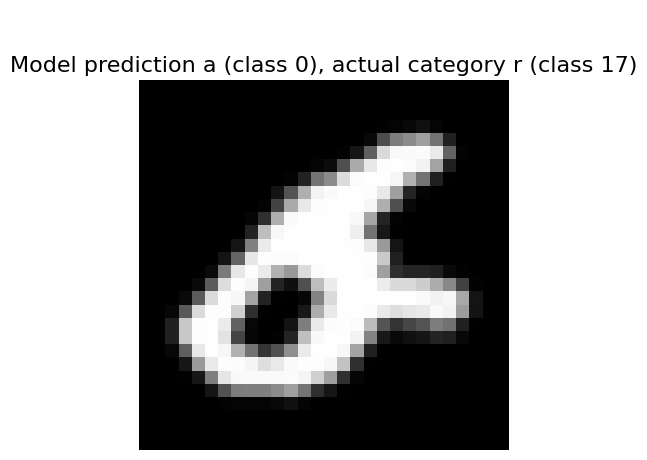

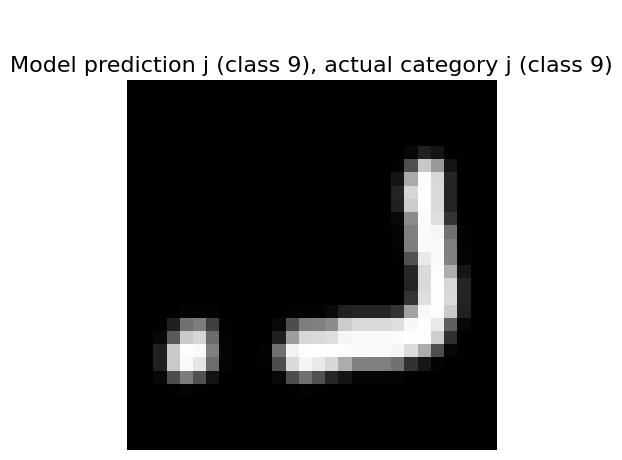

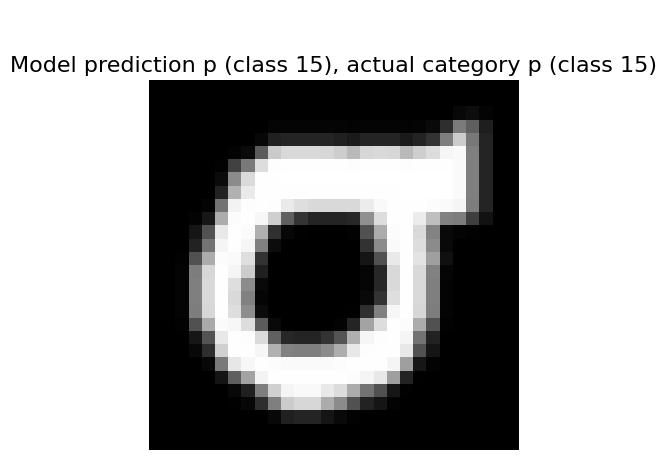

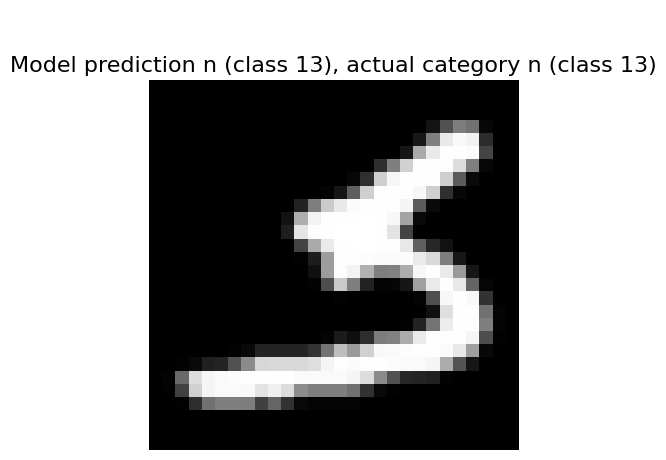

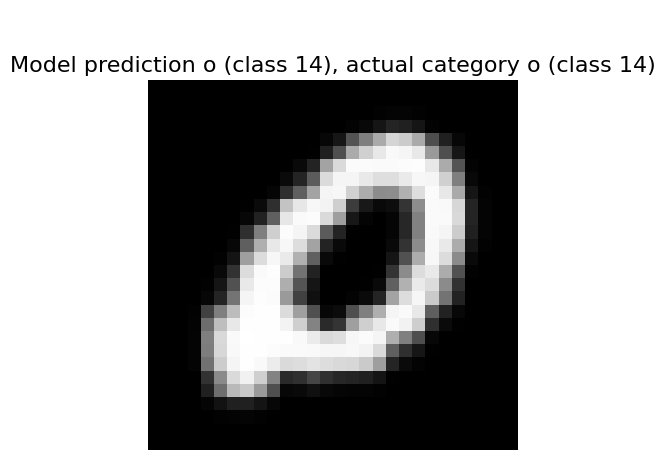

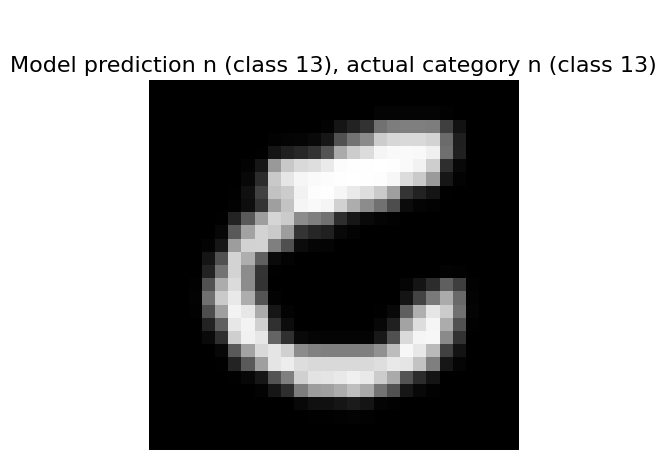

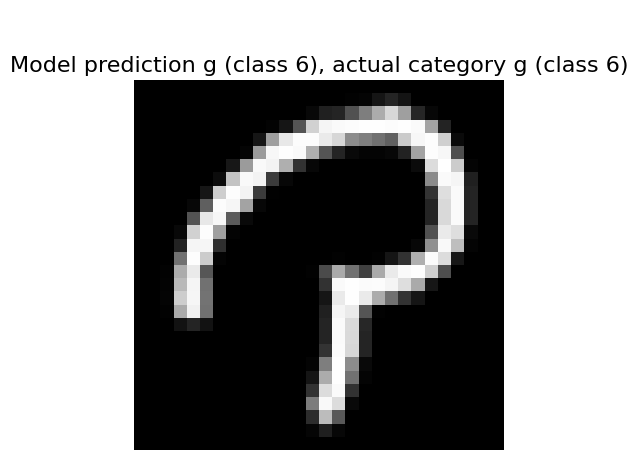

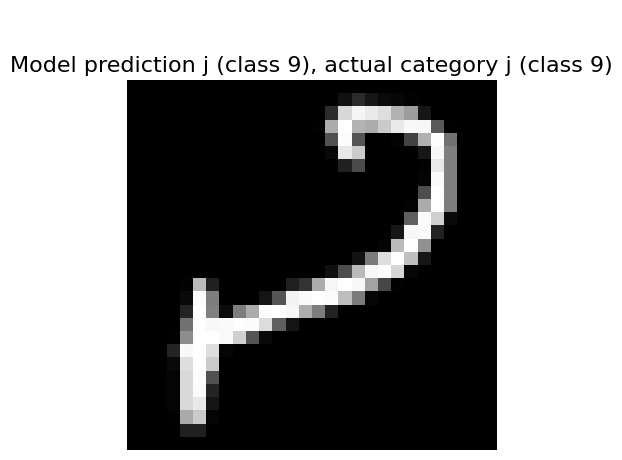

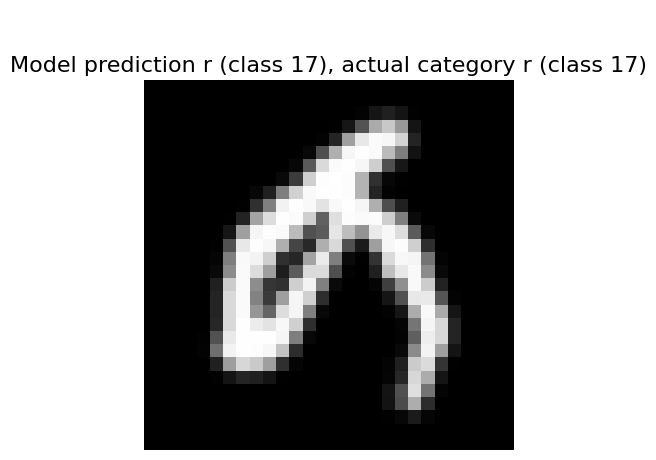

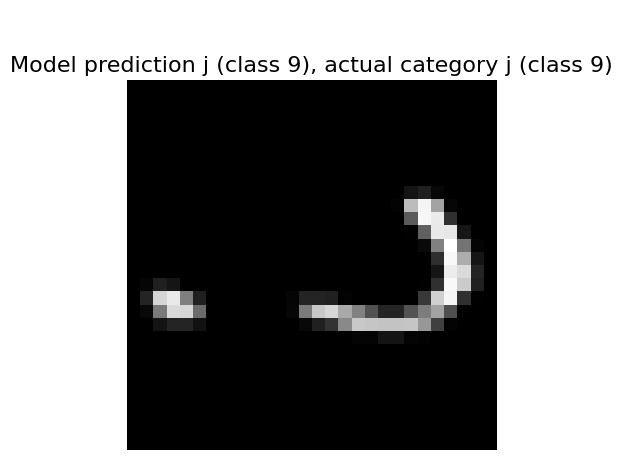

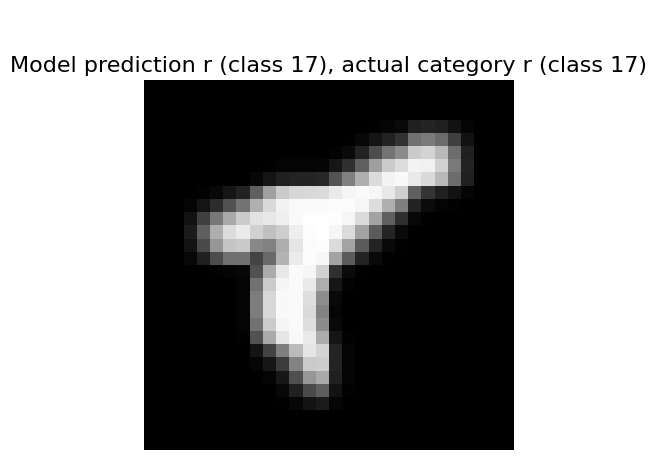

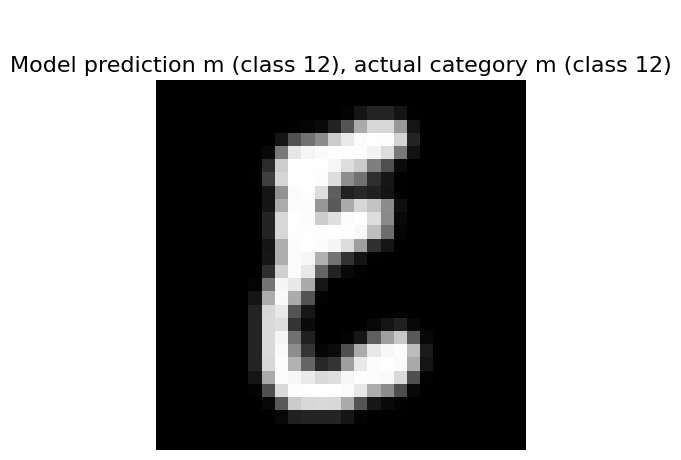

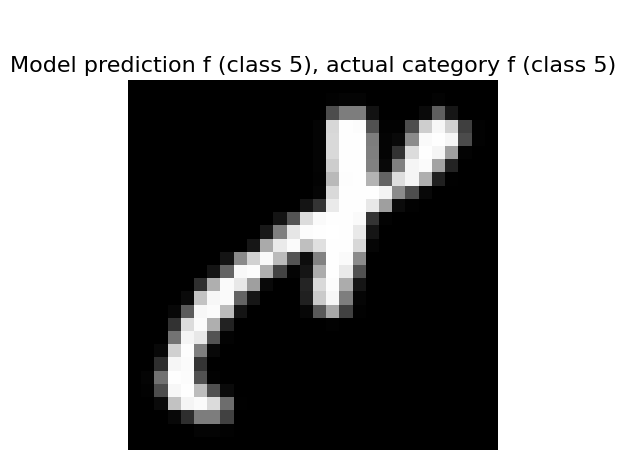

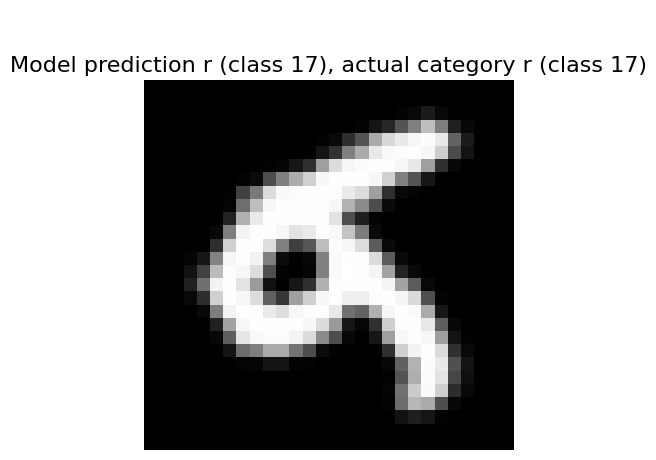

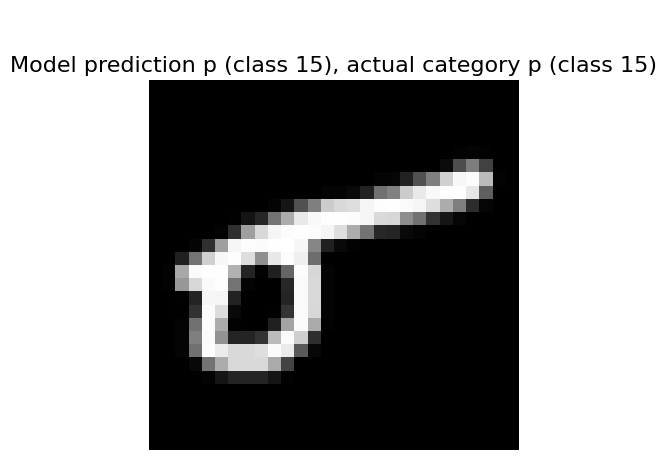

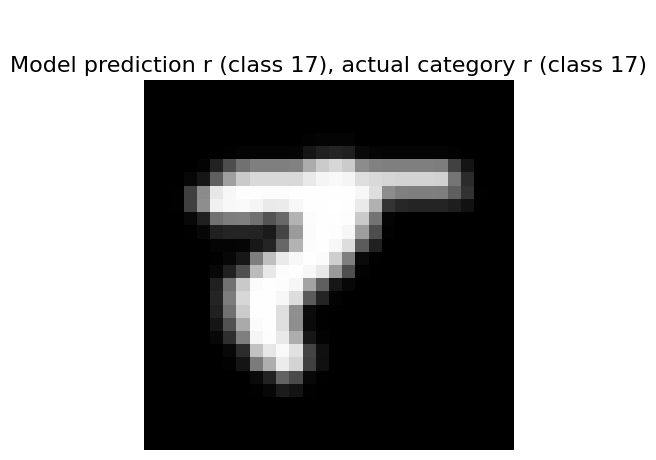

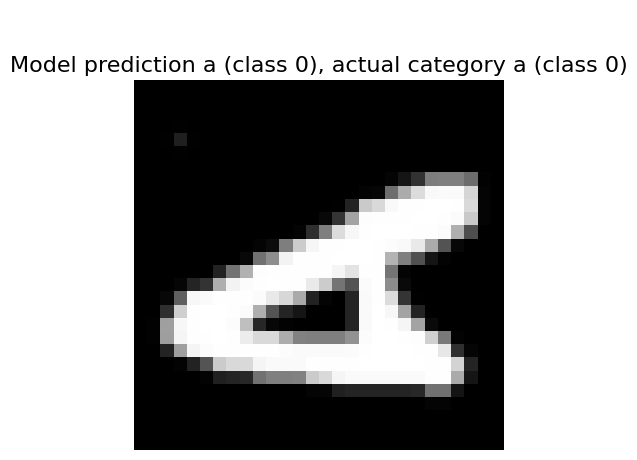

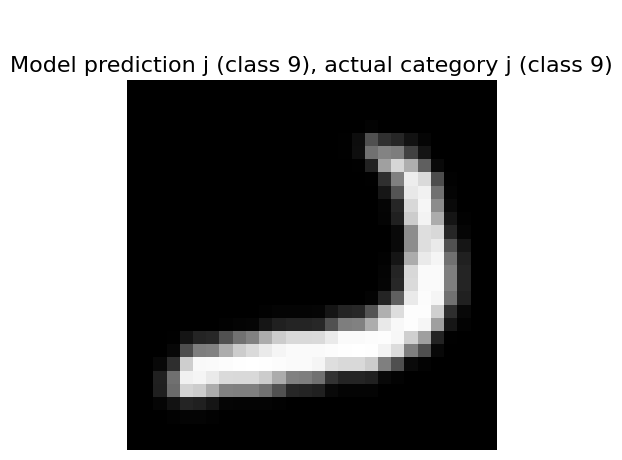

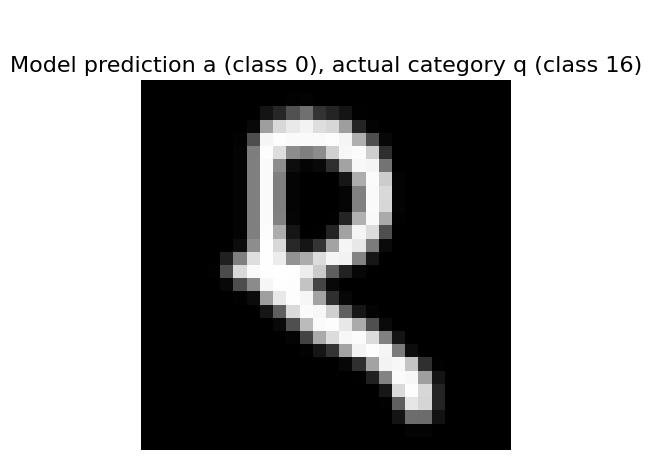

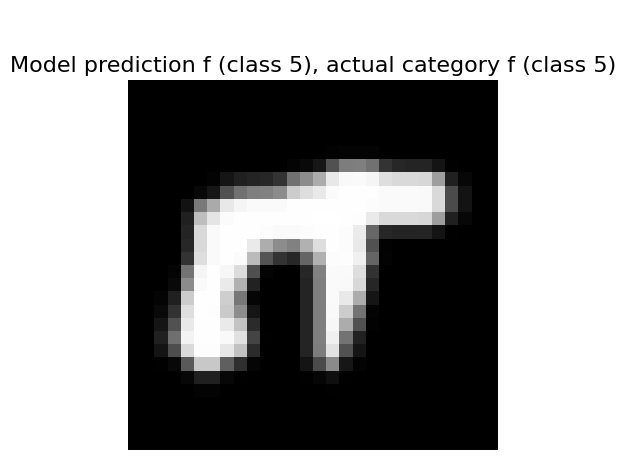

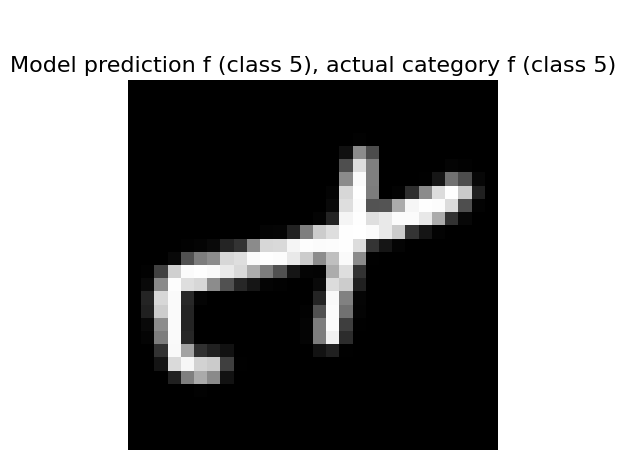

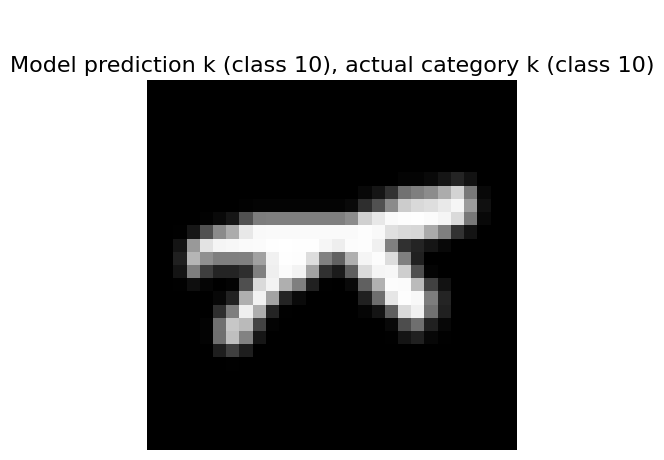

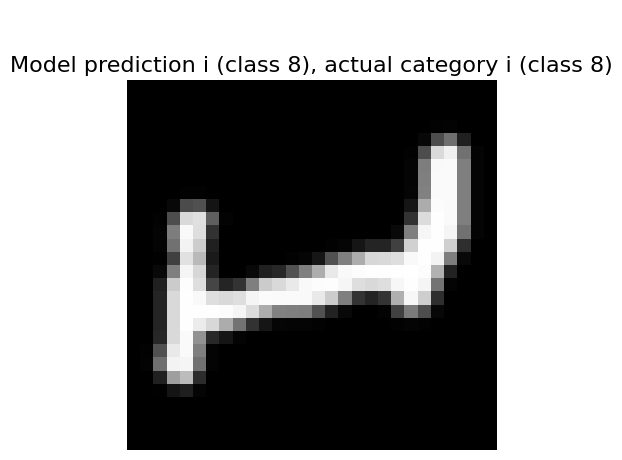

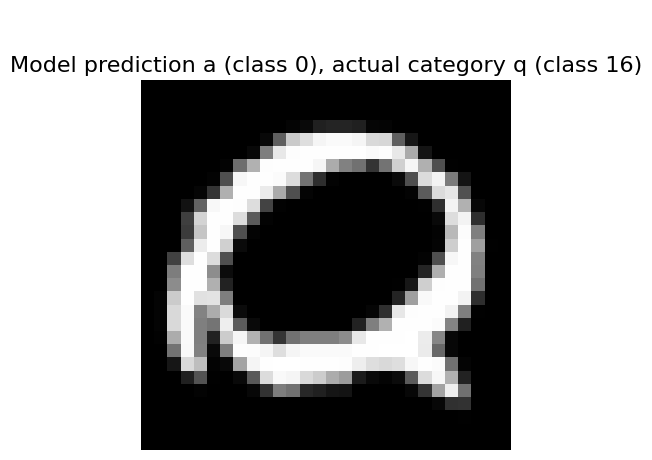

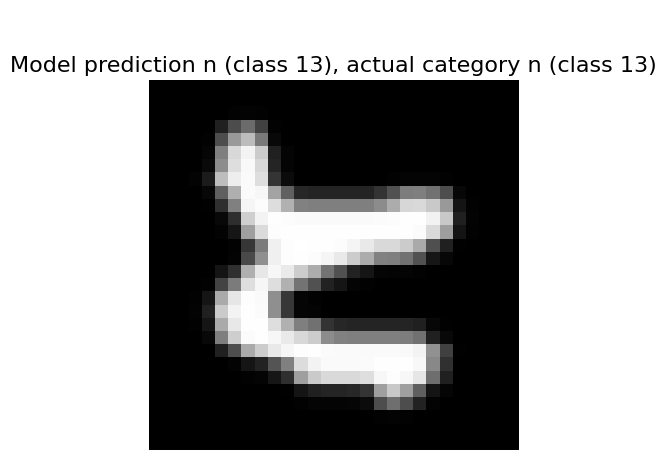

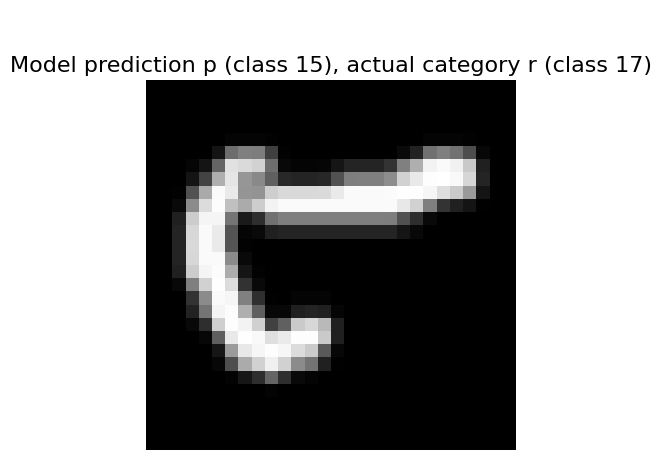

In [31]:
for i in range(64): # iterate over the images
    predicted_class = np.argmax(predictions[i]) # get the predicted class
    actual_class = test_labels[i].long().item()-1 # get the actual class

    show(i, "Model prediction {} (class {}), actual category {} (class {})".format(  
          classes[predicted_class], predicted_class,
          classes[actual_class], actual_class
    )) # show the image

## Evaluating Model Performance with Confusion Matrix

Accuracy on test data: 0.9085749037097102


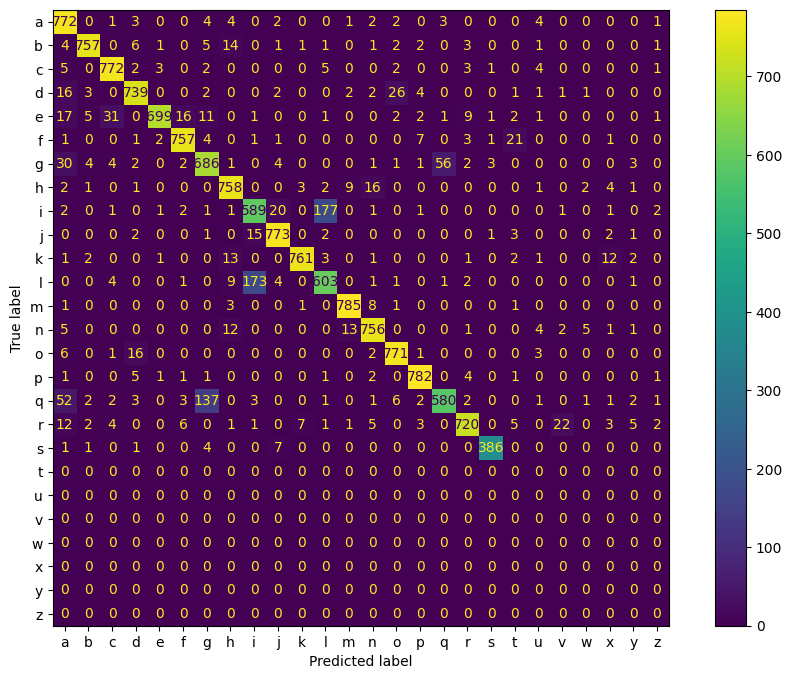

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = [] # initialize the predicted labels
y_true = [] # initialize the true labels

# iterate over test data
for inputs, labels in test_dataloader:
        output = loaded_model.predict(inputs.numpy().reshape(-1, 1, 28, 28)) # Feed Network

        output = np.argmax(output, axis = 1).astype("float64").tolist() # Get Predictions
        y_pred.extend(output) # Append Predictions

        labels = [ x-1 for x in labels.tolist()] # Get True Labels
        y_true.extend(labels) # Append True Labels

acc = accuracy_score(y_true, y_pred) # calculate the accuracy
print('Accuracy on test data:', acc) # print the accuracy

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred) # build the confusion matrix
cmp = ConfusionMatrixDisplay(cm, display_labels = classes) # display the confusion matrix

fig, ax = plt.subplots(figsize = (12, 8)) # create a figure
cmp.plot(ax = ax) # plot the confusion matrix

In [33]:
np.trace(cm) / len(test_dataset) # calculate the accuracy

0.9085749037097102

It comes the same and hence verified

## Hyperparameter Optimization with Hyperopt

In [34]:
from hyperopt import fmin, tpe, hp, Trials # import the hyperopt functions

search_space = {
    # Learning rate in log space
    "lr": hp.loguniform("lr", -10, -8), # learning rate
    "l1": hp.choice("l1", [32, 64, 128]), # number of neurons in the first layer
    "l2": hp.choice("l2", [64, 128, 256]), # number of neurons in the second layer
}

## Defining the EMNIST Model with Hyperparameters

In [35]:
class EmnistModel(pl.LightningModule): # inherit from pl.LightningModule
    def __init__(self, hparams): # initialize the class
        super().__init__() # initialize the parent class

        self.save_hyperparameters(hparams) # save the hyperparameters

        self.criterion = nn.CrossEntropyLoss() # define the loss function

        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1), # 32*28*28
            nn.ReLU(), # activation function
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1), #64*28*28
            nn.ReLU(), # activation function
            nn.MaxPool2d(2, 2), #64*14*14

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1), #128*14*14
            nn.ReLU(), # activation function
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1), #256*14*14
            nn.ReLU(), # activation function
            nn.MaxPool2d(2, 2), #256*7*7

            nn.Flatten(), # flatten
            nn.Linear(256*7*7, self.hparams["l1"]), # linear layer
            nn.ReLU(), # activation function
            nn.Linear(self.hparams["l1"], self.hparams["l2"]), # linear layer
            nn.ReLU(), # activation function
            nn.Linear(self.hparams["l2"], 26) # linear layer
        )

    def forward(self, xb): # forward pass
        return self.network(xb.reshape(-1, 1, 28, 28)) # reshape the input and pass it through the network

    def configure_optimizers(self): # configure the optimizer
        return optim.Adam(self.parameters(), lr = self.hparams["lr"]) # return the optimizer

    def training_step(self, batch, batch_idx): # training step
        x, y = batch # get data and labels
        y -= 1 # subtract 1 from the labels

        y_hat = self(x) # get predictions
        loss = self.criterion(y_hat, y.long()) # get the loss
        pred = y_hat.argmax(dim = 1) # get the predictions

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26) # calculate the accuracy

        self.log("train_loss", loss, on_epoch = True) # log the training loss
        self.log("train_acc", acc, on_epoch = True) # log the training accuracy

        return loss # return the loss

    def validation_step(self, batch, batch_idx): # validation step
        x, y = batch # get data and labels
        y -= 1 # subtract 1 from the labels

        y_hat = self(x) # get predictions
        loss = self.criterion(y_hat, y.long()) # get the loss
        pred = y_hat.argmax(dim = 1) # get the predictions

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26) # calculate the accuracy

        self.log("valid_loss", loss, on_epoch = True) # log the validation loss
        self.log("valid_acc", acc, on_epoch = True) # log the validation accuracy

        return acc # return the accuracy

    def test_step(self, batch, batch_idx): # test step
        x, y = batch # get data and labels
        y -= 1 # subtract 1 from the labels

        y_hat = self(x) # get predictions
        loss = self.criterion(y_hat, y.long()) # get the loss
        pred = y_hat.argmax(dim = 1) # get the predictions

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26) # calculate the accuracy

        self.log("test_loss", loss) # log the test loss
        self.log("test_acc", acc) # log the test accuracy

        return acc # return the accuracy

    def predict_step(self, batch, batch_idx, dataloader_idx = 0): # predict step
        x, y = batch # get data and labels

        return self(x) # get the predictions

## Hyperparameter Optimization Function

In [36]:
# Define a function to perform hyperparameter optimization with Hyperopt
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema, TensorSpec

def train_emnist(params): # train the model
   with mlflow.start_run(nested = True): # start the mlflow run

        model = EmnistModel(params) # create an instance of the model

        trainer = pl.Trainer(max_epochs = 10, accelerator = "gpu") # create a trainer object 

        trainer.fit(model, train_dataloaders = train_dataloader, val_dataloaders = val_dataloader) # fit the model

        train_loss = trainer.callback_metrics["train_loss"].item() # get the training loss from the trainer
        train_acc = trainer.callback_metrics["train_acc"].item() # get the training accuracy from the trainer
        valid_loss = trainer.callback_metrics["valid_loss"].item() # get the validation loss from the trainer
        valid_acc = trainer.callback_metrics["valid_acc"].item() # get the validation accuracy from the trainer

        mlflow.log_params(params) # log the hyperparameters

        mlflow.log_metrics({
            "train_loss_avg": train_loss, "train_acc_avg": train_acc, 
            "valid_loss_avg": valid_loss, "valid_acc_avg": valid_acc}
        )

        input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1, 28, 28))]) # define the input schema
        output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))]) # define the output schema

        signature = ModelSignature(inputs = input_schema, outputs = output_schema) # define the signature

        mlflow.pytorch.log_model(model, "emnist-letters-classifier-cnn-model", signature = signature) # log the model

        return -valid_acc # return the negative validation accuracy

## Running Hyperparameter Optimization

In [37]:
with mlflow.start_run(): # start the mlflow run
    best_result = fmin( #perform the hyperparameter optimization with Hyperopt. "fmin" is a function used to find the set of hyperparameter values that minimize a specified objective function
        fn = train_emnist, # the objective function to minimize
        space = search_space, # the search space
        algo = tpe.suggest, # the algorithm to use
        max_evals = 10, # the maximum number of evaluations
    )

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2025/01/04 09:51:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/pytorch/_lightning_autolog.py:465: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.9.0 and 2.4.0 and may not succeed with packages outside this range."

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 804 K  | train
-------------------------------------------------------
804 K     Trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:51:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:51:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:52:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:52:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:52:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:53:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:53:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:53:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:53:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:54:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 09:54:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 09:54:24 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 10%|█         | 1/10 [03:18<29:49, 198.85s/trial, best loss: -0.9296091794967651]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 793 K  | train
-------------------------------------------------------
793 K     Trainable params
0         Non-trainable params
793 K     Total params
3.172     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:54:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:55:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:55:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:55:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:55:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:56:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:56:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:56:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:57:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:57:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 09:57:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 09:57:34 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 20%|██        | 2/10 [06:28<25:48, 193.61s/trial, best loss: -0.9296091794967651]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 2.0 M  | train
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.054     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:57:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:58:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:58:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:58:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:59:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:59:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 09:59:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:00:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:00:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:00:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 10:00:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 10:00:46 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 30%|███       | 3/10 [09:41<22:31, 193.11s/trial, best loss: -0.9368172287940979]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 1.2 M  | train
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.810     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:01:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:01:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:01:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:01:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:02:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:02:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:02:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:03:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:03:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:03:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 10:03:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 10:03:57 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 40%|████      | 4/10 [12:52<19:13, 192.24s/trial, best loss: -0.9368172287940979]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 1.2 M  | train
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.810     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:04:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:04:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:04:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:05:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:05:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:05:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:06:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:06:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:06:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:06:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 10:06:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 10:07:07 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 50%|█████     | 5/10 [16:02<15:57, 191.49s/trial, best loss: -0.9368172287940979]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 804 K  | train
-------------------------------------------------------
804 K     Trainable params
0         Non-trainable params
804 K     Total params
3.218     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:07:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:07:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:08:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:08:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:08:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:08:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:09:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:09:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:09:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:10:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 10:10:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 10:10:18 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 60%|██████    | 6/10 [19:13<12:45, 191.33s/trial, best loss: -0.9368172287940979]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 2.0 M  | train
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.014     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:10:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:10:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:11:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:11:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:11:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:12:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:12:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:12:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:13:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:13:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 10:13:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 10:13:36 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 70%|███████   | 7/10 [22:30<09:40, 193.36s/trial, best loss: -0.9368172287940979]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 1.2 M  | train
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.810     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:13:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:14:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:14:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:14:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:15:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:15:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:15:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:16:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:16:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:16:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 10:16:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 10:16:48 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 80%|████████  | 8/10 [25:43<06:26, 193.02s/trial, best loss: -0.9368172287940979]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 2.0 M  | train
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.133     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:17:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:17:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:17:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:18:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:18:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:18:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:19:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:19:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:19:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:19:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 10:19:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 10:20:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

 90%|█████████ | 9/10 [29:00<03:14, 194.27s/trial, best loss: -0.9368172287940979]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 804 K  | train
-------------------------------------------------------
804 K     Trainable params
0         Non-trainable params
804 K     Total params
3.218     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:20:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:20:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:21:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:21:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:21:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:21:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:22:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:22:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:22:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Validation: |          | 0/? [00:00<?, ?it/s]

2025/01/04 10:23:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2025/01/04 10:23:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/01/04 10:23:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-gen

100%|██████████| 10/10 [32:11<00:00, 193.19s/trial, best loss: -0.9368172287940979]


## Displaying the Best Hyperparameters

In [38]:
best_result # print the best result

{'l1': 2, 'l2': 1, 'lr': 0.00014869107009541317}

## Evaluating the Best Hyperparameters

In [39]:
import hyperopt # import the hyperopt library
 
print(hyperopt.space_eval(search_space, best_result)) # print the best hyperparameters

{'l1': 128, 'l2': 128, 'lr': 0.00014869107009541317}


## Loading and Predicting with the Best Model

In [43]:
import mlflow
logged_model = 'file:///content/mlruns/507501602153471105/0d51fb214f0f41369da502fe5555c8cb/artifacts/emnist-letters-classifier-cnn-model' # get the path of the logged model

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model) # load the model

# Predict on a Pandas DataFrame

predictions = loaded_model.predict(test_imgs.numpy().reshape(-1, 1, 28, 28)) # get predictions

predictions[:5] # print the predictions

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model) # load the model

# Predict on a Pandas DataFrame

predictions = loaded_model.predict(test_imgs.numpy().reshape(-1, 1, 28, 28)) # get predictions

predictions[:5] # print the predictions

array([[  8.498551  ,  -6.187385  , -13.100406  , -15.441359  ,
          0.17340365,  -1.2130703 ,  11.093438  ,  -5.3204713 ,
         -8.127394  , -13.995815  ,  -5.404771  , -10.738543  ,
        -14.641201  ,  -6.376002  , -13.522231  ,   1.344086  ,
         14.83579   ,   6.1066995 ,  -1.5365117 ,   0.7505781 ,
        -17.169086  , -15.2479    , -14.019589  ,   3.3866787 ,
         -3.6436095 ,   2.5447223 ],
       [ -7.066574  , -12.004612  ,  -9.421676  ,  -6.564358  ,
        -23.288965  , -17.810541  ,  -1.0994349 ,   0.12267103,
        -11.126106  , -12.283839  ,  -5.443965  ,  -5.9161253 ,
         14.733851  ,  12.81576   , -11.313915  ,   1.5400001 ,
         -1.266319  ,  -2.9025316 , -18.709814  , -12.086226  ,
        -12.092938  ,  -0.16855118,  -2.8910096 ,  -9.438541  ,
         -2.0131845 , -28.14406   ],
       [ -5.5644    ,  -7.924754  ,  -4.1528635 ,  -4.0382133 ,
         -8.699454  ,  -7.8698797 ,  -2.8237834 ,  -4.645318  ,
          6.4332004 ,   2.0475

## Evaluating the Best Model on Test Data

In [44]:
from sklearn.metrics import accuracy_score

y_pred = [] # initialize the predicted labels
y_true = [] # initialize the true labels

# iterate over test data
for inputs, labels in test_dataloader: # iterate over the test data
        output = loaded_model.predict(inputs.numpy().reshape(-1, 1, 28, 28)) # Feed Network

        output = np.argmax(output, axis = 1).astype('float64').tolist() # Get Predictions
        y_pred.extend(output) # Append Predictions

        labels = [ x-1 for x in labels.tolist()] # Get True Labels
        y_true.extend(labels) # Append True Labels

acc = accuracy_score(y_true, y_pred) # calculate the accuracy
print('Accuracy on test data:', acc) # print the accuracy

Accuracy on test data: 0.9220893303601595


## Transitioning Model Version to Staging and Assigning Alias

In [45]:
from mlflow import MlflowClient # import the MlflowClient

client = MlflowClient() # create an instance of the MlflowClient
client.transition_model_version_stage( # transition the model version stage
    name="emnist_cnn_classification", # model name
    version=1, # model version
    stage="Staging", # stage
    archive_existing_versions=False # archive existing versions
)


<ipython-input-45-54b9ba24dd1d>:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1735988730136, current_stage='Staging', description='', last_updated_timestamp=1735989041976, name='emnist_cnn_classification', run_id='0d51fb214f0f41369da502fe5555c8cb', run_link='', source='file:///content/mlruns/507501602153471105/0d51fb214f0f41369da502fe5555c8cb/artifacts/emnist-letters-classifier-cnn-model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [46]:
from mlflow import MlflowClient

# Initialize an MLflow Client
client = MlflowClient() # create an instance of the MlflowClient

def assign_alias_to_stage(model_name, stage, alias): # assign an alias to the stage
    """
    Assign an alias to the latest version of a registered model within a specified stage.

    :param model_name: The name of the registered model.
    :param stage: The stage of the model version for which the alias is to be assigned. Can be
                "Production", "Staging", "Archived", or "None".
    :param alias: The alias to assign to the model version.
    :return: None
    """
    latest_mv = client.get_latest_versions(model_name, stages=[stage])[0] # get the latest version
    client.set_registered_model_alias(model_name, alias, latest_mv.version) # set the registered model alias

# Parameters
model_name = "emnist_cnn_classification" # model name
version = "1" # model version
stage = "Staging" # stage
alias = "staging" # alias

# Transition the model version to the Staging stage
client.transition_model_version_stage( # transition the model version stage
    name=model_name, # model name
    version=version, # model version
    stage=stage # stage
)

# Assign an alias to the model version
assign_alias_to_stage(model_name, stage, alias) # assign an alias to the stage


<ipython-input-46-bb648e759f3b>:26: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
<ipython-input-46-bb648e759f3b>:16: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_mv = client.get_latest_versions(model_name, stages=[stage])[0]


## This marks the conclusion of the finalization of the model.